<a href="https://colab.research.google.com/github/prantik-pdeb/prantik-pdeb/blob/main/Systems_Biology_PINN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Systems biology informed deep learning for inferring parameters and hidden dynamics**

In this work Yazdani et al. [2] has developed a new systems-biology-informed
deep learning algorithm that incorporates the system of ordinary differential equations into the neural networks.
Using few scattered and noisy measurements, they are able to infer the dynamics of unobserved species, external forcing, and the unknown model parameters. They have successfully tested the algorithm for three different benchmark problems [2]. Here, I executed,


*   Ultradian endocrine model for glucose-insulin interaction [1]

Yazdani et al.[2] has introduce a new deep learning ***method—systems-informed neural networks*** based on the method of physics-informed neural networks [3, 4], to infer the hidden dynamics of experimentally unobserved species as well as the unknown parameters in the
system of equations.

In this paper [2], they have assumed that the systems biological process can be modeled by a system of ordinary differential equations (ODEs) in the follwing way;

\begin{equation}
\frac{dx}{dt} = f(x, t, p) \tag{1a}
\end{equation}

\begin{equation}
x(T_0) = x_0 \tag{1b}
\end{equation}

\begin{equation}
y = h(x) + \epsilon(t); \quad \epsilon(t) \sim \mathcal{N}(0, \sigma^2) \tag{1c}
\end{equation}

where the state vector \(x = (x_1, x_2, ..., x_S)\) represents the concentration of \(S\) **species**, and \(p = (p_1, p_2, ..., p_K)\) are \(K\) parameters of the model, which remain to be determined. Hence, the system of ODEs will be identified once \(p\) is known. \(y = (y_1, y_2, ..., y_M)\) are the \(M\) measurable signals (consistent with the ODE system).

## **Systems-biology informed neural networks (SBINN)** :

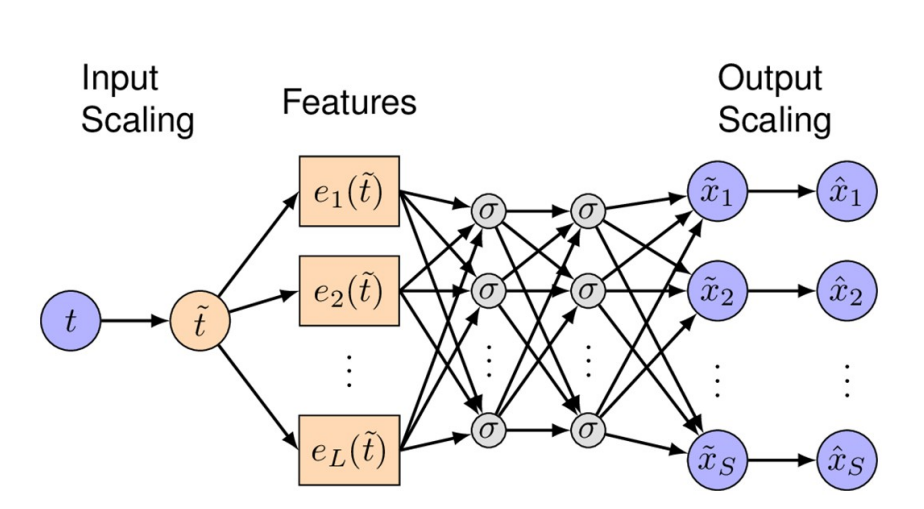

Here, Swish function $\text{Swish}(x) = \frac{x}{1 + e^{-x}}$ as the activation function $\sigma$.


Total loss is defined as a function of both $\theta$ and $p$:

\begin{equation}
L(\theta, p) = L_{\text{data}}(\theta) + L_{\text{ode}}(\theta, p) + L_{\text{aux}}(\theta) \tag{3}
\end{equation}

where,

\begin{equation}
L_{\text{data}}(\theta) = \sum_{m=1}^{M} w_{\text{data}_m} L_{\text{data}_m} = \sum_{m=1}^{M} w_{\text{data}_m} \frac{1}{N_{\text{data}}} \sum_{n=1}^{N_{\text{data}}} (y_m(t_n) - \hat{x}^s_m(t_n; \theta))^2 \tag{4}
\end{equation}

\begin{equation}
L_{\text{ode}}(\theta, p) = \sum_{s=1}^{S} w_{\text{ode}_s} L_{\text{ode}_s} = \sum_{s=1}^{S} w_{\text{ode}_s} \frac{1}{N_{\text{ode}}}\sum_{n=1}^{N_{\text{ode}}} \left(\frac{dx^s}{dt}\bigg|_{t_n} - f_s\left(t_n, x^s(t_n; \theta), p\right)\right)^2 \tag{5}
\end{equation}

\begin{equation}
L_{\text{aux}}(\theta) = \sum_{s=1}^{S} w_{\text{aux}_s} L_{\text{aux}_s} = \sum_{s=1}^{S} w_{\text{aux}_s} \left((x_s(T_0) - \hat{x}^s(T_0; \theta))^2 + (x_s(T_1) - \hat{x}^s(T_1; \theta))^2\right) \tag{6}
\end{equation}


Here, $L_{\text{data}}$ and $L_{\text{aux}}$ are the discrepancy between the network and measurements, and thus they are *supervised losses*, while $L_{\text{ode}}$ is based on the ODE system, and thus is *unsupervised*.

In [ ]:
!pip install deepxde

In [ ]:
# Importing DeepXDE and the TensorFlow backend
import numpy as np
from scipy.integrate import odeint
import deepxde as dde
from deepxde.backend import tf

In [ ]:
import numpy as np
from scipy.integrate import odeint
def glucose_insulin_model(
    t,
    meal_t,
    meal_q,
    Vp=3,
    Vi=11,
    Vg=10,
    E=0.2,
    tp=6,
    ti=100,
    td=12,
    k=1 / 120,
    Rm=209,
    a1=6.6,
    C1=300,
    C2=144,
    C3=100,
    C4=80,
    C5=26,
    Ub=72,
    U0=4,
    Um=90,
    Rg=180,
    alpha=7.5,
    beta=1.772,
):
    def func(y, t):
        f1 = Rm / (1 + np.exp(-y[2] / Vg / C1 + a1))
        f2 = Ub * (1 - np.exp(-y[2] / Vg / C2))
        kappa = (1 / Vi + 1 / E / ti) / C4
        f3 = (U0 + Um / (1 + (kappa * y[1]) ** (-beta))) / Vg / C3
        f4 = Rg / (1 + np.exp(alpha * (y[5] / Vp / C5 - 1)))
        IG = np.sum(
            meal_q * k * np.exp(k * (meal_t - t)) * np.heaviside(t - meal_t, 0.5)
        )
        tmp = E * (y[0] / Vp - y[1] / Vi)
        return [
            f1 - tmp - y[0] / tp,
            tmp - y[1] / ti,
            f4 + IG - f2 - f3 * y[2],
            (y[0] - y[3]) / td,
            (y[3] - y[4]) / td,
            (y[4] - y[5]) / td,
        ]

    Vp0, Vi0, Vg0 = 3, 11, 10
    y0 = [12 * Vp0, 4 * Vi0, 110 * Vg0 ** 2, 0, 0, 0]
    return odeint(func, y0, t)


meal_t = np.array([300, 650, 1100, 2000])
meal_q = np.array([60e3, 40e3, 50e3, 100e3])
t = np.arange(0, 3000, 1)[:, None]
y = glucose_insulin_model(np.ravel(t), meal_t, meal_q)
np.savetxt("glucose.dat", np.hstack((t, y)))
np.savetxt("meal.dat", np.hstack((meal_t, meal_q)))

In [ ]:
import numpy as np
import deepxde as dde
from deepxde.backend import tf


def sbinn(data_t, data_y, meal_t, meal_q):
    def get_variable(v, var):
        low, up = v * 0.2, v * 1.8
        l = (up - low) / 2
        v1 = l * tf.tanh(var) + l + low
        return v1

    E_ = dde.Variable(0.0)
    tp_ = dde.Variable(0.0)
    ti_ = dde.Variable(0.0)
    td_ = dde.Variable(0.0)
    k_ = dde.Variable(0.0)
    Rm_ = dde.Variable(0.0)
    a1_ = dde.Variable(0.0)
    C1_ = dde.Variable(0.0)
    C2_ = dde.Variable(0.0)
    C4_ = dde.Variable(0.0)
    C5_ = dde.Variable(0.0)
    Ub_ = dde.Variable(0.0)
    U0_ = dde.Variable(0.0)
    Um_ = dde.Variable(0.0)
    Rg_ = dde.Variable(0.0)
    alpha_ = dde.Variable(0.0)
    beta_ = dde.Variable(0.0)

    var_list_ = [
        E_,
        tp_,
        ti_,
        td_,
        k_,
        Rm_,
        a1_,
        C1_,
        C2_,
        C4_,
        C5_,
        Ub_,
        U0_,
        Um_,
        Rg_,
        alpha_,
        beta_,
    ]

    def ODE(t, y):
        Ip = y[:, 0:1]
        Ii = y[:, 1:2]
        G = y[:, 2:3]
        h1 = y[:, 3:4]
        h2 = y[:, 4:5]
        h3 = y[:, 5:6]

        Vp = 3
        Vi = 11
        Vg = 10
        E = (tf.tanh(E_) + 1) * 0.1 + 0.1
        tp = (tf.tanh(tp_) + 1) * 2 + 4
        ti = (tf.tanh(ti_) + 1) * 40 + 60
        td = (tf.tanh(td_) + 1) * 25 / 6 + 25 / 3
        k = get_variable(0.0083, k_)
        Rm = get_variable(209, Rm_)
        a1 = get_variable(6.6, a1_)
        C1 = get_variable(300, C1_)
        C2 = get_variable(144, C2_)
        C3 = 100
        C4 = get_variable(80, C4_)
        C5 = get_variable(26, C5_)
        Ub = get_variable(72, Ub_)
        U0 = get_variable(4, U0_)
        Um = get_variable(90, Um_)
        Rg = get_variable(180, Rg_)
        alpha = get_variable(7.5, alpha_)
        beta = get_variable(1.772, beta_)

        f1 = Rm * tf.math.sigmoid(G / (Vg * C1) - a1)
        f2 = Ub * (1 - tf.math.exp(-G / (Vg * C2)))
        kappa = (1 / Vi + 1 / (E * ti)) / C4
        f3 = (U0 + Um / (1 + tf.pow(tf.maximum(kappa * Ii, 1e-3), -beta))) / (Vg * C3)
        f4 = Rg * tf.sigmoid(alpha * (1 - h3 / (Vp * C5)))
        dt = t - meal_t
        IG = tf.math.reduce_sum(
            0.5 * meal_q * k * tf.math.exp(-k * dt) * (tf.math.sign(dt) + 1),
            axis=1,
            keepdims=True,
        )
        tmp = E * (Ip / Vp - Ii / Vi)
        dIP_dt = dde.grad.jacobian(y, t, i=0, j=0)
        dIi_dt = dde.grad.jacobian(y, t, i=1, j=0)
        dG_dt = dde.grad.jacobian(y, t, i=2, j=0)
        dh1_dt = dde.grad.jacobian(y, t, i=3, j=0)
        dh2_dt = dde.grad.jacobian(y, t, i=4, j=0)
        dh3_dt = dde.grad.jacobian(y, t, i=5, j=0)
        return [
            dIP_dt - (f1 - tmp - Ip / tp),
            dIi_dt - (tmp - Ii / ti),
            dG_dt - (f4 + IG - f2 - f3 * G),
            dh1_dt - (Ip - h1) / td,
            dh2_dt - (h1 - h2) / td,
            dh3_dt - (h2 - h3) / td,
        ]

    geom = dde.geometry.TimeDomain(data_t[0, 0], data_t[-1, 0])

    # Observes
    n = len(data_t)
    idx = np.append(
        np.random.choice(np.arange(1, n - 1), size=n // 5, replace=False), [0, n - 1]
    )
    observe_y2 = dde.PointSetBC(data_t[idx], data_y[idx, 2:3], component=2)

    np.savetxt("glucose_input.dat", np.hstack((data_t[idx], data_y[idx, 2:3])))

    data = dde.data.PDE(geom, ODE, [observe_y2], anchors=data_t)

    net = dde.maps.FNN([1] + [128] * 3 + [6], "swish", "Glorot normal")

    def feature_transform(t):
        t = 0.01 * t
        return tf.concat(
            (t, tf.sin(t), tf.sin(2 * t), tf.sin(3 * t), tf.sin(4 * t), tf.sin(5 * t)),
            axis=1,
        )

    net.apply_feature_transform(feature_transform)

    def output_transform(t, y):
        idx = 1799
        k = (data_y[idx] - data_y[0]) / (data_t[idx] - data_t[0])
        b = (data_t[idx] * data_y[0] - data_t[0] * data_y[idx]) / (
            data_t[idx] - data_t[0]
        )
        linear = k * t + b
        factor = tf.math.tanh(t) * tf.math.tanh(idx - t)
        return linear + factor * tf.constant([1, 1, 1e2, 1, 1, 1]) * y

    net.apply_output_transform(output_transform)

    model = dde.Model(data, net)

    firsttrain = 10000
    callbackperiod = 1000
    maxepochs = 1000000

    model.compile("adam", lr=1e-3, loss_weights=[0, 0, 0, 0, 0, 0, 1e-2])
    model.train(epochs=firsttrain, display_every=1000)
    model.compile(
        "adam",
        lr=1e-3,
        loss_weights=[1, 1, 1e-2, 1, 1, 1, 1e-2],
        external_trainable_variables=var_list_,
    )
    variablefilename = "variables.csv"
    variable = dde.callbacks.VariableValue(
        var_list_, period=callbackperiod, filename=variablefilename
    )
    losshistory, train_state = model.train(
        epochs=maxepochs, display_every=1000, callbacks=[variable]
    )

    dde.saveplot(losshistory, train_state, issave=True, isplot=True)


gluc_data = np.hsplit(np.loadtxt("/content/glucose.dat"), [1])
meal_data = np.hsplit(np.loadtxt("/content/meal.dat"), [4])

t = gluc_data[0]
y = gluc_data[1]
meal_t = meal_data[0]
meal_q = meal_data[1]

sbinn(
    t[:1800],
    y[:1800],
    meal_t,
    meal_q,
)

variable_file(10000, 1000, 1000000, "variables.csv")

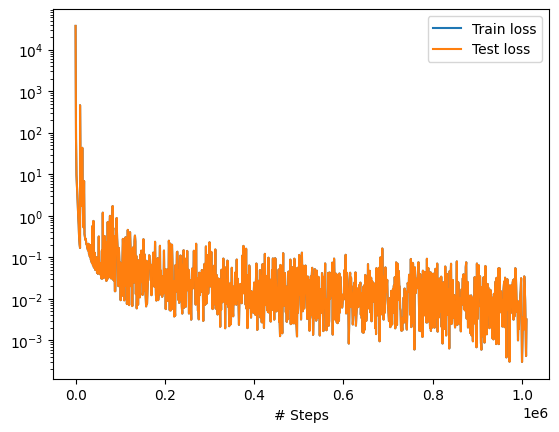

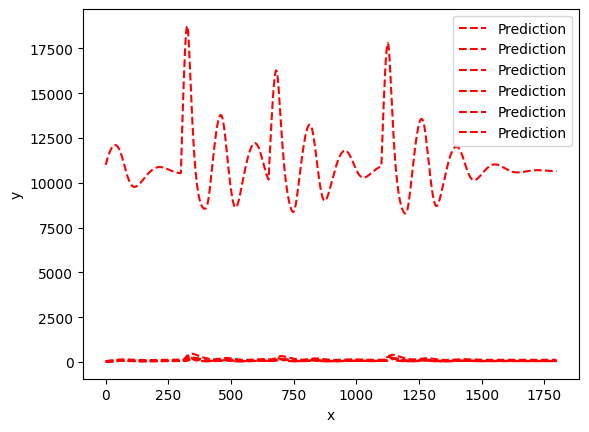

The prediction obtained from here is the model's estimate of the glucose concentration over time based on the given input data (glucose concentration measurements and meal information).

The neural network learns to approximate the solution to the differential equations governing the glucose-insulin system and provides predictions that best fit the observed data. To evaluate the quality of the prediction and the model's performance, additional analysis, such as comparing the predicted glucose concentration with the actual measurements or assessing the model's ability to generalize to unseen data, would be necessary.

In [ ]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.8.2" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia BenchmarkTools"
JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  nvidia-smi -L &> /dev/null && export GPU=1 || export GPU=0
  if [ $GPU -eq 1 ]; then
    JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia

  echo ''
  echo "Successfully installed `julia -v`!"
  echo "Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then"
  echo "jump to the 'Checking the Installation' section."
fi

In [ ]:
versioninfo()

In [ ]:
# Install LaTeX packages
run(`apt-get install texlive texlive-xetex texlive-latex-extra pandoc`)

In [ ]:
import Pkg; Pkg.add("DifferentialEquations")
import Pkg; Pkg.add("ForwardDiff")
import Pkg; Pkg.add("DiffResults")
import Pkg; Pkg.add("DiffEqSensitivity")
import Pkg; Pkg.add("DataFrames")
import Pkg; Pkg.add("CSV")
import Pkg; Pkg.add("Dierckx")
import Pkg; Pkg.add("StatsPlots")
import Pkg; Pkg.add("LaTeXStrings")
import Pkg; Pkg.add("Plots")

using DifferentialEquations
using ForwardDiff
using DiffResults
using DiffEqSensitivity
using Statistics
using Random
using LinearAlgebra
using DataFrames
using CSV
using Dierckx
using Plots
using StatsPlots
using LaTeXStrings

function f_apop(dx, x, p, t)
    x1, x2, x3, x4, x5, x6 = x
    E, tp, ti, td, k, Rm, a1, C1, C2, C4, C5, Ub, U0, Um, Rg, alpha, beta = p
    Vp = 3
    Vi = 11
    Vg = 10
    C3 = 100/100
    meal_t = 300, 650, 1100
    meal_q = 60e3, 40e3, 50e3
    f1 = Rm / (1 + exp(x3 / (Vg * C1) - a1))
    f2 = Ub * (1 - exp(-x3 / (Vg * C2)))
    kappa = (1 / Vi + 1 / (E * ti)) / C4
    f3 = (U0 + Um / (1 + (kappa * x2)^(-beta))) / (Vg * C3)
    f4 = Rg / (1 + exp(alpha * (1 - x6 / (Vp * C5))))
    dt1 = t - meal_t[1]
    dt2 = t - meal_t[2]
    dt3 = t - meal_t[3]
    IG1 = 0.5 * meal_q[1] * k * exp(-k * dt1) * (sign(dt1) + 1)
    IG2 = 0.5 * meal_q[2] * k * exp(-k * dt2) * (sign(dt2) + 1)
    IG3 = 0.5 * meal_q[3] * k * exp(-k * dt3) * (sign(dt3) + 1)
    IG = IG1 + IG2 + IG3
    tmp = E * (x1 / Vp - x2 / Vi)
    dx[1] = (f1 - tmp - x1 / tp)
    dx[2] = (tmp - x2 / ti)
    dx[3] = (f4 + IG - f2 - f3 * x3)
    dx[4] = (x1 - x4) / td
    dx[5] = (x4 - x5) / td
    dx[6] = (x5 - x6) / td
end

cscale = 1; tscale = 1.;
p = [0.200853979,5.986360211,101.2036365,11.97776077,0.00833154,208.6221286,6.592132806,301.2623884,37.65196466,78.75855574,25.93801618,71.32611075,4.063671595,88.97766871,179.85672,7.536059566,1.783340558]

x0 = [36., 44., 11000., 0., 0., 0.] / cscale
tspan = (0.0, 1800.0)
prob_apop = ODELocalSensitivityProblem(f_apop, x0, tspan, p)

sol_apop = solve(prob_apop, alg_hints=[:stiff], saveat=0.1)
x_apop, dp_apop = extract_local_sensitivities(sol_apop)

lab = [L"E", L"tp", L"ti", L"td", L"k", L"Rm", L"a1", L"C1", L"C2", L"C4", L"C5", L"Ub", L"U0", L"Um", L"Rg", L"alpha", L"beta"]
σ = 0.01 * std(x_apop, dims=2)
cov_ϵ = σ[4]
dp = dp_apop
cols = 4:4

plot(sol_apop.t, x_apop[4,:], lw=2)

Nt = length(dp[1][1,:])
Nstate = length(dp[1][:,1])
Nparam = length(dp[:,1])
F = zeros(Float64, Nparam, Nparam)

perm = vcat(1, sort(rand(2:Nt-1, Nt÷5)), Nt)

for i in perm
    S = reshape(dp[1][:,i], (Nstate,1))
    for j = 2:Nparam
        S = hcat(S, reshape(dp[j][:,i], (Nstate,1)))
    end
    global F += S[cols,:]' * inv(cov_ϵ) * S[cols,:]
end

C = inv(F)
R = ones(size(C))
R = [C[i,j]/sqrt(C[i,i]*C[j,j]) for i = 1:size(C)[1], j = 1:size(C)[1]]
heatmap(R, xlims=(0.5,size(R)[1]+0.5), aspect_ratio = 1, color = :inferno, clims = (-1, 1),
        xticks = (1:1:size(C)[1], lab), xtickfont = font(14, "Times"),
        yticks = (1:1:size(C)[1], lab), ytickfont = font(14, "Times"), fmt = :pdf, dpi=300)
savefig("correlation_matrix")

abs.(R) .> 0.99

lowerbound = sqrt.(diag(inv(F))) / tscale
lowerbound[1:3:7] = lowerbound[1:3:7] / cscale
for i = 1:length(lab)
    println(lab[i], '\t', lowerbound[i])
end

for i = 1:Nparam
    println(eigvals(F)[i])
    println(eigvecs(F)[:,i])
    println('\n')
end

bar(eigvecs(F)[:,1:9], ylabel = "FIM null eigenvector coefficients", ytickfont = font(12, "Times"),
    xticks = (1:1:size(C)[1], lab), xtickfont = font(12, "Courier"),
    legendfontsize = 10, label = [L"null_1" L"null_2" L"null_3" L"null_4" L"null_5" L"null_6" L"null_7" L"null_8" L"null_9"], fmt = :png,
    legend=:topright, dpi=300)
savefig("nulleigen_apop")

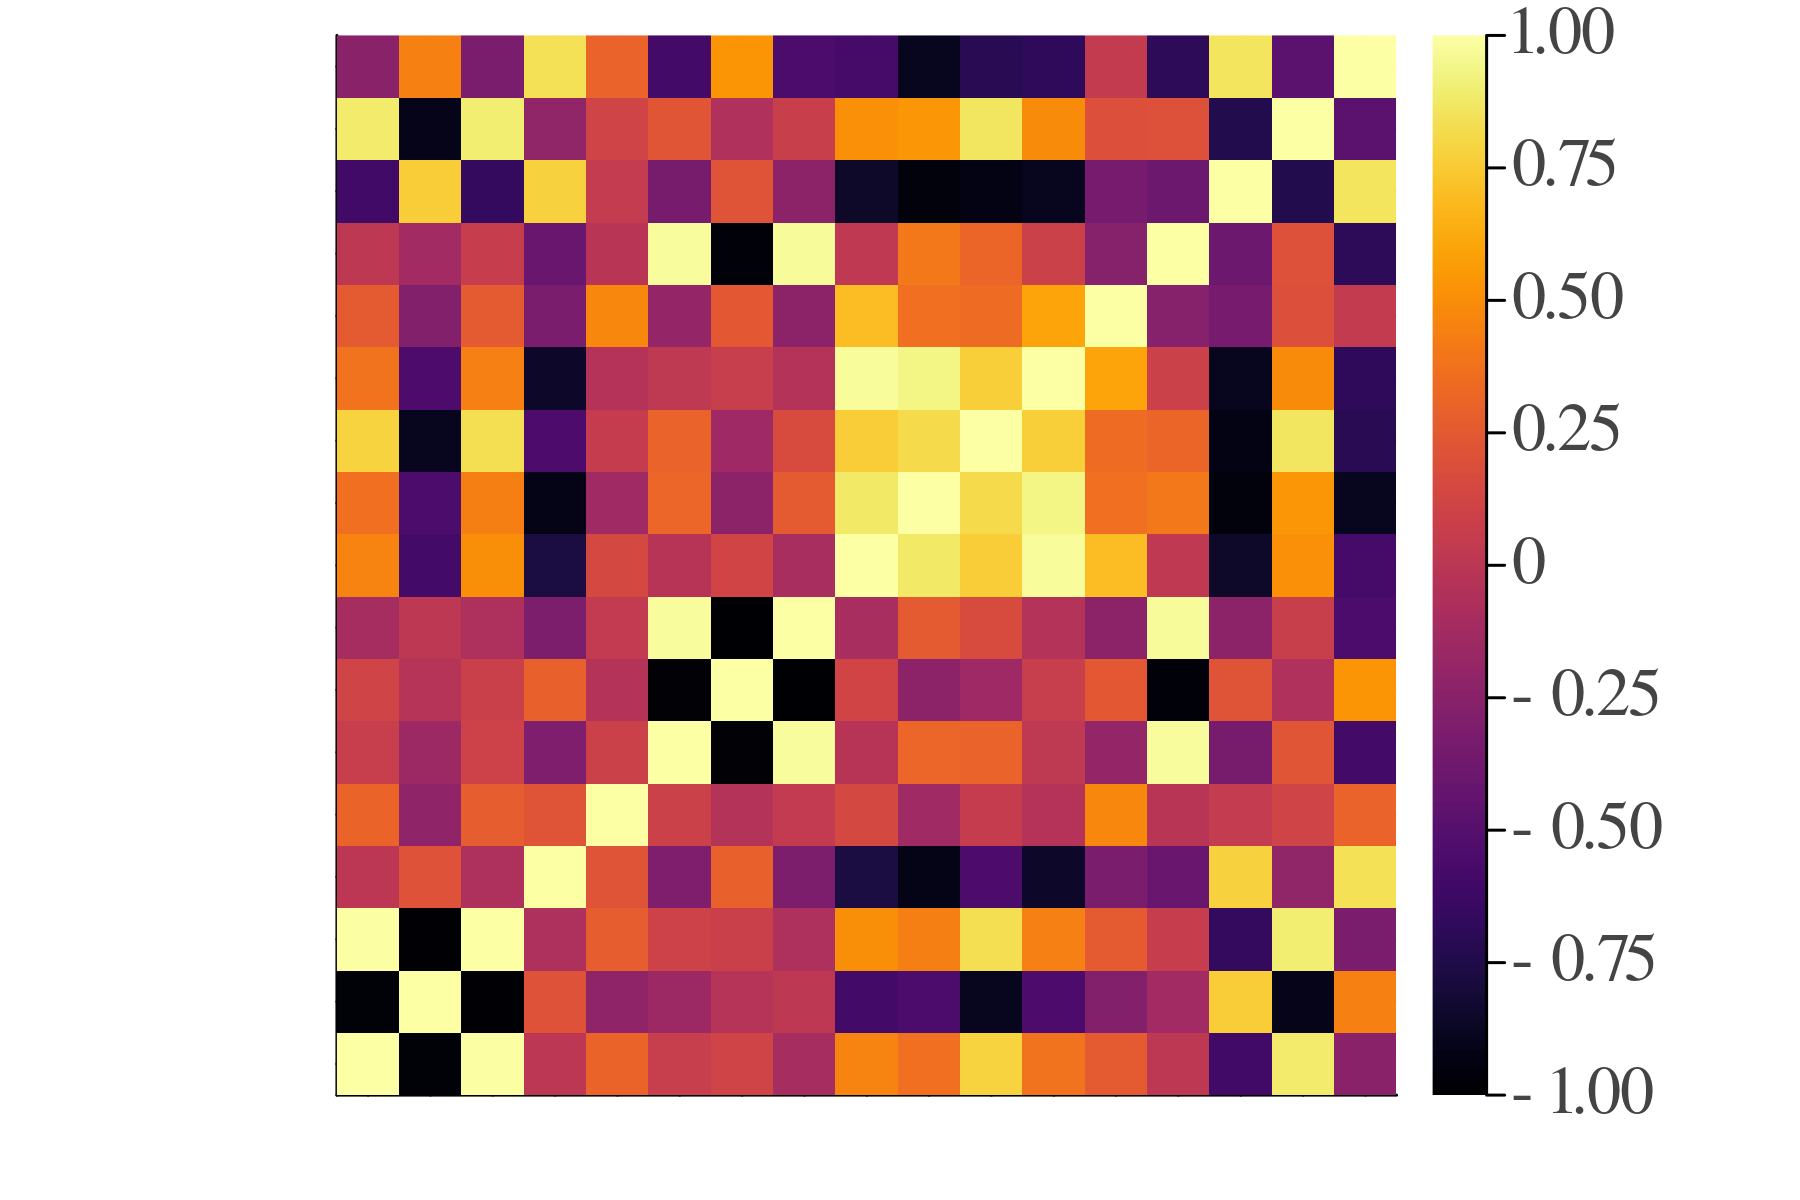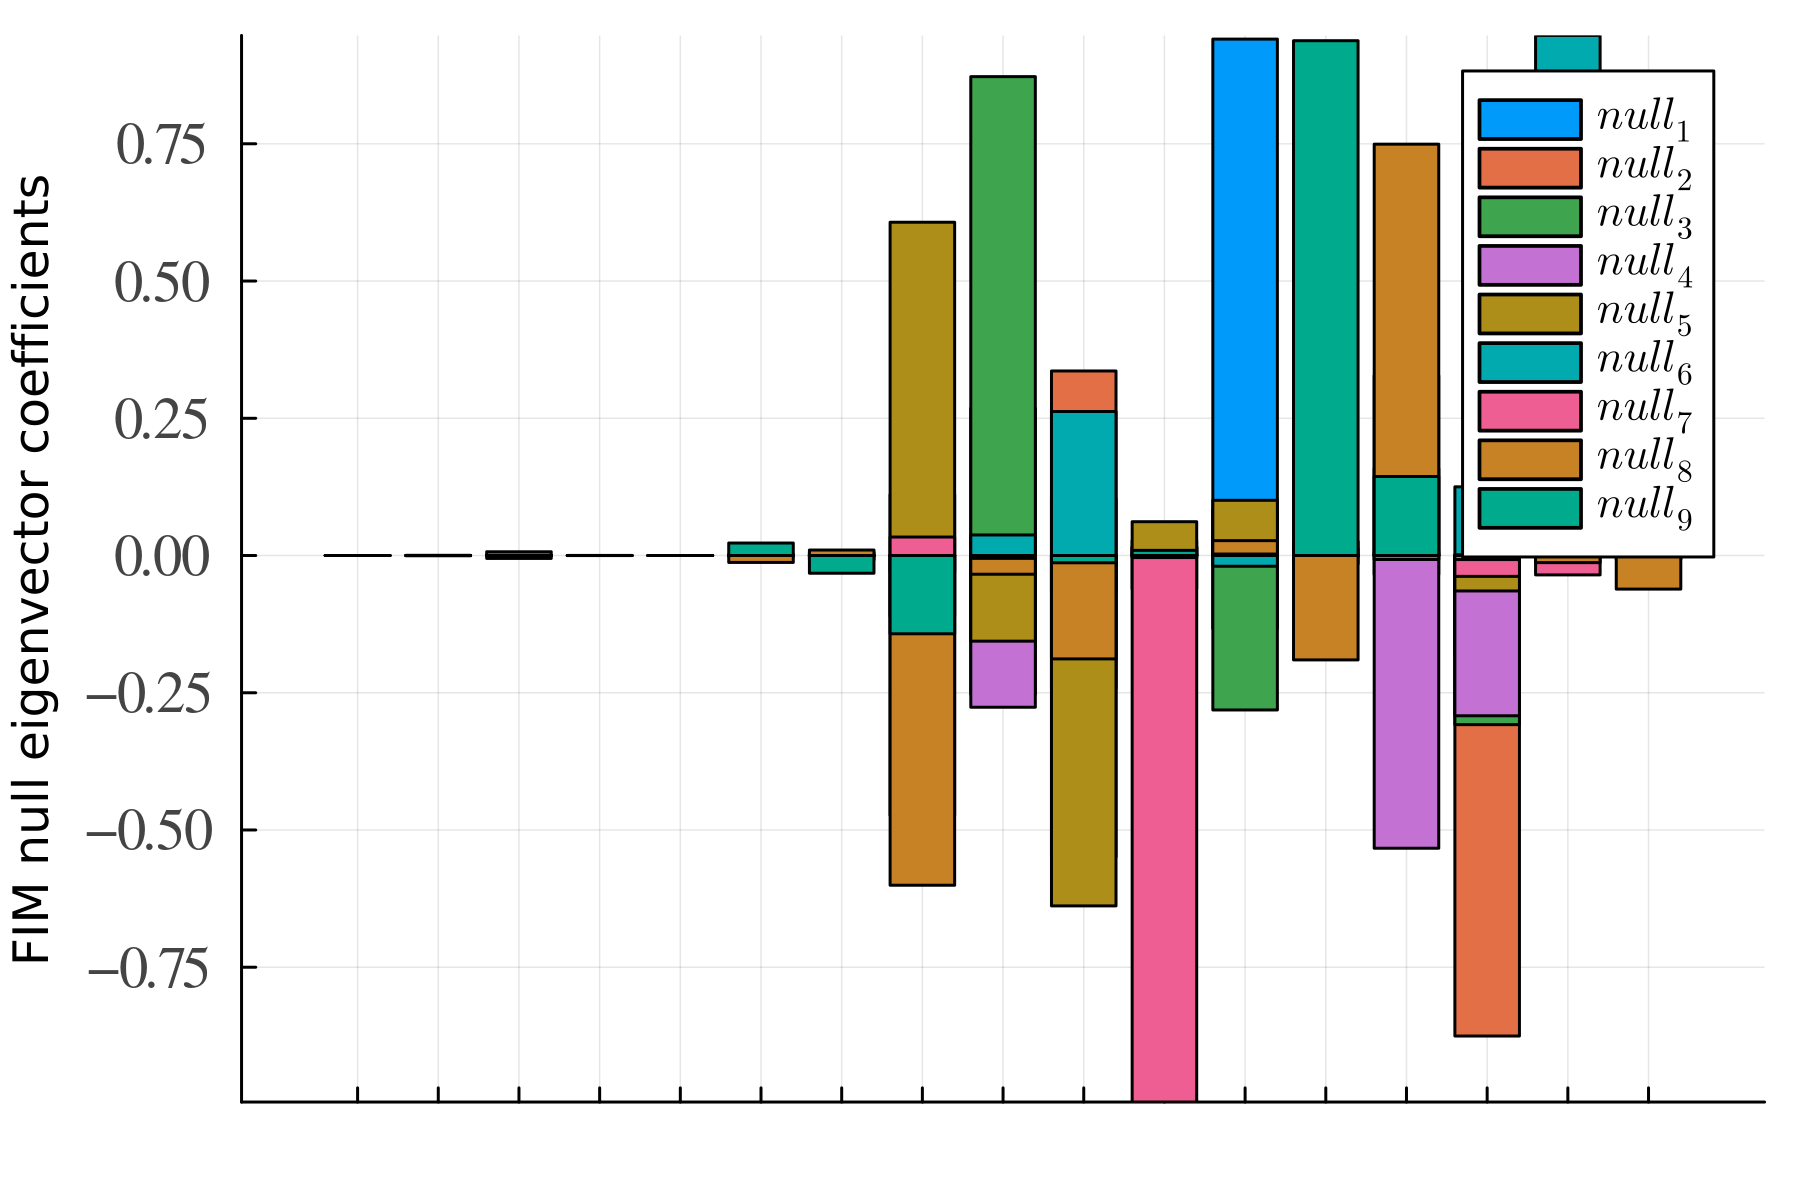

# Structural Identifiability Analysis:

Here, test for the local identifiability of the system since the existing software packages may suffer from out-of-memory issues when testing the global identifiability of a system with a large number of state variables and a small number of observables.
So, in this paper Daneker et al. [2]  refered to a system as being identifiable when it is structually locally identifiable. Using the ***Julia library*** Structural Identifiability [5] to test for structural identifiability of the model.

In [ ]:
using Pkg
Pkg.add("StructuralIdentifiability")

In [ ]:
import Pkg
Pkg.add("ModelingToolkit")

In [ ]:
using StructuralIdentifiability

# Define the ODE model
ode = @ODEmodel(
    Ip'(t) = 209/g1(t) - E*(Ip(t)/Vp - Ii(t)/Vi) - Ip(t)/tp,
    Ii'(t) = E*(Ip(t)/Vp - Ii(t)/Vi) - Ii(t)/ti,
    G'(t) = Rg/g4(t) + IG(t) - Ub*g2(t) - (U0 + Um/g3(t))/Vg/100*G(t),
    h1'(t) = (Ip(t) - h1(t))/td,
    h2'(t) = (h1(t) - h2(t))/td,
    h3'(t) = (h2(t) - h3(t))/td,
    g1'(t) = -(g1(t)-1)/Vg/C1*(Rg/g4(t) + IG(t) - Ub*g2(t) - (U0 + Um/g3(t))/Vg/100*G(t)),
    g2'(t) = -(g2(t)-1)/Vg/C2*(Rg/g4(t) + IG(t) - Ub*g2(t) - (U0 + Um/g3(t))/Vg/100*G(t)),
    g3'(t) = -beta*(g3(t)-1)/Ii(t)*(E*(Ip(t)/Vp - Ii(t)/Vi) - Ii(t)/ti),
    g4'(t) = alpha/26/Vp*(g4(t)-1)*(h2(t) - h3(t))/td,
    # Data Available
    y(t) = G(t),  # Data of G
    y2(t) = Ip(t), # Use this line , if we also have data of Ip
    y3(t) = Ii(t),  # Use this line , if we also have data of Ii
)

In [ ]:
print(assess_local_identifiability(ode))

In [ ]:
print(assess_local_identifiability(ode))

In [ ]:
# Given G, I_p, I_i, infer all parameters case
ode2 = @ODEmodel(
    Ip'(t) = 209 / g1(t) - E * (Ip(t) / Vp - Ii(t) / Vi) - Ip(t) / tp,
    Ii'(t) = E * (Ip(t) / Vp - Ii(t) / Vi) - Ii(t) / ti,
    G'(t) = Rg / g4(t) + IG(t) - Ub * g2(t) - (U0 + Um / g3(t)) / Vg / 100 * G(t),
    h1'(t) = (Ip(t) - h1(t)) / td,
    h2'(t) = (h1(t) - h2(t)) / td,
    h3'(t) = (h2(t) - h3(t)) / td,
    g1'(t) = -(g1(t)-1)/Vg/C1*(Rg / g4(t) + IG(t) - Ub * g2(t) - (U0 + Um / g3(t)) / Vg / 100 * G(t)),
    g2'(t) = -(g2(t)-1)/Vg/C2*(Rg / g4(t) + IG(t) - Ub * g2(t) - (U0 + Um / g3(t)) / Vg / 100 * G(t)),
    g3'(t) = -beta*(g3(t)-1)/Ii(t)*(E * (Ip(t) / Vp - Ii(t) / Vi) - Ii(t) / ti),
    g4'(t) = alpha / 26 / Vp * (g4(t)-1) * (h2(t) - h3(t)) / td,
    y1(t) = G(t),
    y2(t) = Ii(t),
    y3(t) = Ip(t)
    )

In [ ]:
print(assess_local_identifiability(ode2))

In [ ]:
# Given G, fix V_p case
ode3 = @ODEmodel(
  Ip'(t) = 209 / g1(t) - E * (Ip(t) / 3 - Ii(t) / Vi) - Ip(t) / tp,
  Ii'(t) = E * (Ip(t) / 3 - Ii(t) / Vi) - Ii(t) / ti,
  G'(t) = Rg / g4(t) + IG(t) - Ub * g2(t) - (U0 + Um / g3(t)) / Vg / 100 * G(t),
  h1'(t) = (Ip(t) - h1(t)) / td,
  h2'(t) = (h1(t) - h2(t)) / td,
  h3'(t) = (h2(t) - h3(t)) / td,
  g1'(t) = -(g1(t)-1)/Vg/C1*(Rg / g4(t) + IG(t) - Ub * g2(t) - (U0 + Um / g3(t)) / Vg / 100 * G(t)),
  g2'(t) = -(g2(t)-1)/Vg/C2*(Rg / g4(t) + IG(t) - Ub * g2(t) - (U0 + Um / g3(t)) / Vg / 100 * G(t)),
  g3'(t) = -beta*(g3(t)-1)/Ii(t)*(E * (Ip(t) / 3 - Ii(t) / Vi) - Ii(t) / ti),
  g4'(t) = alpha / 26 / 3 * (g4(t)-1) * (h2(t) - h3(t)) / td,
  y(t) = G(t)
  )

In [ ]:
print(assess_local_identifiability(ode3))

In [ ]:
#Given G, fix V_p, V_i case
ode4 = @ODEmodel(
  Ip'(t) = 209 / g1(t) - E * (Ip(t) / 3 - Ii(t) / 11) - Ip(t) / tp,
  Ii'(t) = E * (Ip(t) / 3 - Ii(t) / 11) - Ii(t) / ti,
  G'(t) = Rg / g4(t) + IG(t) - Ub * g2(t) - (U0 + Um / g3(t)) / Vg / 100 * G(t),
  h1'(t) = (Ip(t) - h1(t)) / td,
  h2'(t) = (h1(t) - h2(t)) / td,
  h3'(t) = (h2(t) - h3(t)) / td,
  g1'(t) = -(g1(t)-1)/Vg/C1*(Rg / g4(t) + IG(t) - Ub * g2(t) - (U0 + Um / g3(t)) / Vg / 100 * G(t)),
  g2'(t) = -(g2(t)-1)/Vg/C2*(Rg / g4(t) + IG(t) - Ub * g2(t) - (U0 + Um / g3(t)) / Vg / 100 * G(t)),
  g3'(t) = -beta*(g3(t)-1)/Ii(t)*(E * (Ip(t) / 3 - Ii(t) / 11) - Ii(t) / ti),
  g4'(t) = alpha / 26 / 3 * (g4(t)-1) * (h2(t) - h3(t)) / td,
  y(t) = G(t)
  )

In [ ]:
print(assess_local_identifiability(ode4))

In [ ]:
# Given G, fix V_p, V_i, V_g case
ode5 = @ODEmodel(
  Ip'(t) = 209 / g1(t) - E * (Ip(t) / 3 - Ii(t) / 11) - Ip(t) / tp,
  Ii'(t) = E * (Ip(t) / 3 - Ii(t) / 11) - Ii(t) / ti,
  G'(t) = Rg / g4(t) + IG(t) - Ub * g2(t) - (U0 + Um / g3(t)) / 10 / 100 * G(t),
  h1'(t) = (Ip(t) - h1(t)) / td,
  h2'(t) = (h1(t) - h2(t)) / td,
  h3'(t) = (h2(t) - h3(t)) / td,
  g1'(t) = -(g1(t)-1)/10/C1*(Rg / g4(t) + IG(t) - Ub * g2(t) - (U0 + Um / g3(t)) / 10 / 100 * G(t)),
  g2'(t) = -(g2(t)-1)/10/C2*(Rg / g4(t) + IG(t) - Ub * g2(t) - (U0 + Um / g3(t)) / 10 / 100 * G(t)),
  g3'(t) = -beta*(g3(t)-1)/Ii(t)*(E * (Ip(t) / 3 - Ii(t) / 11) - Ii(t) / ti),
  g4'(t) = alpha / 26 / 3 * (g4(t)-1) * (h2(t) - h3(t)) / td,
  y(t) = G(t) )

In [ ]:
print(assess_local_identifiability(ode5))

# Reference:

[1] Daneker, Mitchell, et al. "Systems biology: Identifiability analysis and parameter identification via systems-biology-informed neural networks." Computational Modeling of Signaling Networks. New York, NY: Springer US, 2023. 87-105.

[2] Yazdani, Alireza, et al. "Systems biology informed deep learning for inferring parameters and hidden dynamics." PLoS computational biology 16.11 (2020): e1007575.

[3] Raissi, Maziar, Paris Perdikaris, and George E. Karniadakis. "Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations." Journal of Computational physics 378 (2019): 686-707.

[4] Lu, Lu, et al. "DeepXDE: A deep learning library for solving differential equations." SIAM review 63.1 (2021): 208-228.
